In [1]:
from examples.offline_RL_workshop.offline_policies.policy_registry import PolicyType
from examples.offline_RL_workshop.offline_trainings.restore_policy_model import restore_trained_offline_policy
from examples.offline_RL_workshop.custom_envs.custom_envs_registration import register_grid_envs
import gymnasium as gym
from examples.offline.utils import load_buffer_minari
from examples.offline_RL_workshop.visualizations.utils import get_state_action_data_and_policy_grid_distributions
from examples.offline_RL_workshop.utils import state_action_histogram, compare_state_action_histograms
import os
import warnings
from tqdm import tqdm
from examples.offline_RL_workshop.custom_envs.custom_envs_registration import RenderMode, CustomEnv
from examples.offline_RL_workshop.behavior_policies.visualize_custom_policies import render_custom_policy_simple_grid
from examples.offline_RL_workshop.behavior_policies.behavior_policy_registry import BehaviorPolicyType
import random
from examples.offline_RL_workshop.generate_custom_datasets.generate_minari_dataset_grid_envs import \
    create_minari_datasets_from_dict
import minari


os.environ["LD_LIBRARY_PATH"] = "/home/ivan/.mujoco/mujoco210/bin"
os.environ["MINARI_DATASETS_PATH"] = "/home/ivan/Documents/GIT_PROJECTS/Tianshou/tianshou/offline_data"
#warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium")
warnings.filterwarnings("ignore")


/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`

InterruptedError: You quited ('q') the iteration.

Introduction:
---

Problem definition: ToDo
Examples of applicability:

In summary, the process is simple: 

Phase A - Collect data set, $D$, of state-action paird through a behavior policy (also known as expert policy) $\pi_b$: e.g. a robot randomly moving (or human controlled) in a given space, data collected from an autonomous vehicle, etc. The data collected doesn't need to come from an expert (typically the case in real situations) and during this phase we are not worry in general about a specific task (i.e. rewards). In fact it could be that the data is collected from a robot doing a different task that the one we are interested in. We want just a set of allowed state-action pairs that could be usable for the task in mind.

Phase B - In this phase we want to solve a given task (so we need to design rewards) only through the provided initial data without any interaction with the environment but still be able to find an optimal or near-optimal policy.

Let's see phase A and B with a simple [example](https://docs.google.com/presentation/d/1-cfO7MNcH6iyN4EwyFjI9F3cVu4hYn5ihCqmZHBeeSk/edit#slide=id.g28654ea4ec6_0_8)

Let's start with phase A.

We have created a set of 2D environments as the one shown before. In all of them agent starts from the position (0,0) and needs to reach the position (grid_size-1, grid_size-1) and there are two version: V0 means free of obstacles and V1 with obstacles (see custom_envs_registration.py for more details). Below you can find the code running the environment.

In [2]:
#ToDo: Embedded the animation in jupyter cell.
# Press 'q' to quit the animation

ENV_NAME = CustomEnv.Grid_2D_8x8_discrete_V1 #"Grid_2D_5x5_discrete-V1"
NUM_STEPS = 1000
RENDER_MODE = RenderMode.RGB_ARRAY_LIST


register_grid_envs()
env = gym.make(ENV_NAME, render_mode=RENDER_MODE)

BEHAVIOR_POLICY =  BehaviorPolicyType.random

render_custom_policy_simple_grid(
    env_name=ENV_NAME,
    render_mode=RENDER_MODE,
    behavior_policy_name=BEHAVIOR_POLICY,
    num_steps=NUM_STEPS,
)

AttributeError: Grid_2D_8x8_discrete_V1

Exercise I: Create a suboptimal policy for the grid env. and visualize it

**hint**: in the 8x8 grid env. we will have 64 states where every state i=0,..,63 is mapped to (x,y) for x,y=0,..,7 . So the suboptimal_policy should be function that accept a np.array shape=(64,) and returns an integer 
between 0 and 4. 


ACTIONS

    0: (-1, 0), #UP
    1: (1, 0),  #DOWN
    2: (0, -1), #LEFT
    3: (0, 1)   #RIGHT


In [3]:
from examples.offline_RL_workshop.utils import one_hot_to_integer
import numpy as np

state , _ = env.reset()
state_value = one_hot_to_integer(state)


def suboptimal_policy(state: np.ndarray, env:gym.Env) -> int:
    state_index = one_hot_to_integer(state)
    state_xy = env.to_xy(state_index)
    
    possible_directions = [2, 3, 1]
    weights = [1, 1, 3]
    random_directions = random.choices(possible_directions, weights=weights)[0]
    
    if state_xy[0] == 7:
        possible_directions = [0, 1, 3]
        weights = [1, 1, 3]
        random_directions = random.choices(possible_directions, weights=weights)[0]
    
    return random_directions
  
    
BEHAVIOR_POLICY =  suboptimal_policy
render_custom_policy_simple_grid(
    env_name=ENV_NAME,
    render_mode=RENDER_MODE,
    behavior_policy=BEHAVIOR_POLICY,
    num_steps=NUM_STEPS,
)

QObject::moveToThread: Current thread (0x55fd2fa78ce0) is not the object's thread (0x55fd2fc197f0).
Cannot move to target thread (0x55fd2fa78ce0)

QObject::moveToThread: Current thread (0x55fd2fa78ce0) is not the object's thread (0x55fd2fc197f0).
Cannot move to target thread (0x55fd2fa78ce0)

QObject::moveToThread: Current thread (0x55fd2fa78ce0) is not the object's thread (0x55fd2fc197f0).
Cannot move to target thread (0x55fd2fa78ce0)

QObject::moveToThread: Current thread (0x55fd2fa78ce0) is not the object's thread (0x55fd2fc197f0).
Cannot move to target thread (0x55fd2fa78ce0)

QObject::moveToThread: Current thread (0x55fd2fa78ce0) is not the object's thread (0x55fd2fc197f0).
Cannot move to target thread (0x55fd2fa78ce0)

QObject::moveToThread: Current thread (0x55fd2fa78ce0) is not the object's thread (0x55fd2fc197f0).
Cannot move to target thread (0x55fd2fa78ce0)

QObject::moveToThread: Current thread (0x55fd2fa78ce0) is not the object's thread (0x55fd2fc197f0).
Cannot move to tar

InterruptedError: You quited ('q') the iteration.

With the random policy and the obstacle in the environment we are able to mimic the example introduced before: the obstacle could be a fragile object or a wall and the agent moves randomly. So let's generate the datset to be use in Phase B (i.e. RL training). 

In order to deal with datasets for offline RL we will follow the [minari](https://minari.farama.org/main/) library that is becoming an standard in the field (Previously D4RL but migrating soon to Minari). Minari is a Python API that hosts a collection of popular Offline Reinforcement Learning datasets that are use for offline RL benchmarkings in the academia. 

Note: Give a look to Minari library.

a - [Datasets](https://minari.farama.org/datasets/door/)

b - [basic usages](https://minari.farama.org/main/content/basic_usage/)

    Exercise II: Create your own minari datase following the tutorial and your custom policies.
    Remember to use the DataCollectorV0 wrapper provided in the library. Load the dataset.


**Note: See later D4RL and MINARI dataset rationale and OPE   TODO !!!**

## Todo: Create two datasets solving different goals and combine them. 
Exercise: compine two minari datasets and show how two datasets intended for different tasks can be reused for a new one.

ToDo: Solve error with delete minari dataset ....

In [ ]:
#Exercise: Create two datasets with the previous custom behavior policies and export to minari format.

##### Exercise HERE !!!! #####

In [5]:
#Let's create the data with our code (escentially Exercise II with a bit of more structure.). See how this works.

DATASET_CONFIG = {
    "env_name": ENV_NAME,
    "data_set_name": ENV_NAME + "_data",
    "num_steps": 3000,
    "behavior_policy": BehaviorPolicyType.behavior_suboptimal_2d_grid_discrete,
}

create_minari_datasets_from_dict(DATASET_CONFIG)


# Create Random dataset --> visualize distributions

# Comment about distribution shift -- pedagogically ...

Dataset /home/ivan/Documents/GIT_PROJECTS/Tianshou/tianshou/offline_data/Grid_2D_8x8_discrete-V1_data downloaded. Size of data: 4


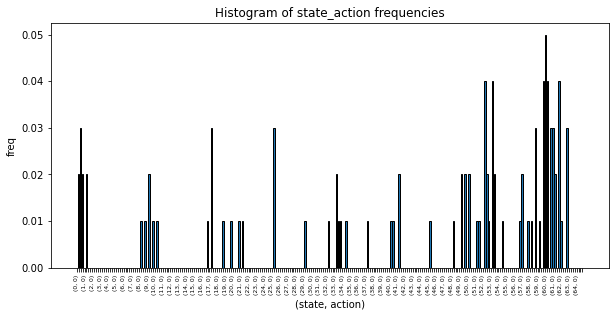

In [10]:
# Load minar data: as we are going to use Tianshou we will load the minari data in a tianshou ReplyBuffer

data = load_buffer_minari(DATASET_CONFIG["data_set_name"])

# Visualize state-action pair data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(data, env, policy=None)
state_action_histogram(state_action_count_data)

#state_action_histogram(state_action_count_policy)
#compare_state_action_histograms(state_action_count_data, state_action_count_policy)


Phase B:

RL policy: Clonning, Dagger:

look at distribution policy vs distribution data

Exercise III: Extract conclusions in teams....


offline SAC, DQN: 

Distribution shift plus ood (training - inference)

Exercise IV: Extract conclusions in teams....

Why is offline RL a difficult problem?


1 - **Not possible to improve exploration**: As the learning algorithm must rely entirely on the static
dataset $D$, there is no possibility of improving exploration: if D does not contain transitions that illustrate high-reward regions for our task it may be impossible to discover those regions. If we explore beyond our data we could have severe problems as there could be a good reason why this data is not in our dataset: maybe there is an obstacle that could damage the robot or a fragile object that could be damaged by the robot!

Note that this is opposite to online RL where you explore by interacting with the environment. 

This is why the collecting data phase is so important!!

2 - **Distributional shift**: state-action pair distribution in $D$ does not accurately represent the distribution of states-actions of the trained policy. This challenges many existing machine learning methods, which assume that data is independent and identically distributed (i.i.d.). In standard supervised learning, we aim to train a model that performs well on data from the same distribution as the training data. In offline RL, our goal is to learn a policy that behaves differently (hopefully better) than what's seen in the dataset $D$. As a consequence (see later) the RL algorithms will tend to generate actions not included in $D$ and so generate **out of distribution actions data**. This could be dangerous as during inference these actions could bring the system to unexplored states (i.e. not included in $D$).

ToDo: See later some example about it. It could be a 2D grid where the data was collected considering an obstacle but in inference we use the same grid without obstacles and we start from an obstacle zone??? ).

- Theory about ood/extrapolation errors. 

- Theory about typology of offline RL algorithms.

- Offline RL famous algorithms: Theory (BCQ, IQL, CQL, etc.)

- Apply RL famous algorithms to 2D grid: 
a - full analysis of OOD, 
b - balance in-distribution vs ood -- performance relationship.
c - Analyse different RL typologies to random and suboptimal policies.

- See Mujoco example and others (this should be done in parallel with the 2D grids) : 
  For instance: see suboptimal policy vs trained policy (IL. BCQ, CQL, etc.)

In [ ]:
!pdfexport presentation.pdf

D4RL: It provides a set of RL evironment and suboptimal policies that generate interesting datasets that try to cover many important requirements a good offline RL algorithm should fullfil. Dataset properties:

1 - **Narrow and biased data distributions**: e.g. from deterministic policies: Narrow datasets may arise in human demonstrations or in hand-crafted policies.

Excercise: combined example and see how offline is much better than offpoliy DQN

2 - **Undirected and multitask data**: Undirected in the sense that is not directed towards the specific task one is trying to accomplish. E.g.: recording user interactions on the internet or recording videos of a car for autonomous driving. 
Main purpose of this property is trajectory 'stitching' (This is my combined example and see how offline is much better than offpoliy DQN), i.e. the combination of trajectories belonging to different tasks to acomplish the new task instead to find o.o.d. trajectories.

Excercise: combined example and see how offline is much better than offpoliy DQN

3 - **Sparse rewards**: in an online setting this is hard as sparse rewards and exploration are highly correlated. As more sparse reward more exploration in general. So isolate the capability of the algorithm to adapt to sparse rewards is difficult when online exploration is present. In offline we only explore within the dataset so it is a good framework to study how well the algorithm react against sparse rewards -- A BIT CONFUSING --> CLARIFY
This is important as reward shaping is a complex task in general and if overengineering could lead to solutions that exploit local optima. In contrast Designing sparse rewards is typically easier since it only requires defining the criteria for solving a task so making
it an appealing property to address.

Excercise: Use the 2D grid examples with sparce and not sparse rewards to see their performanc

4 - **Suboptimal data**: Give a clear task the data could not contain any optimal trajectory so this is the realistic scenario in general

Excercise: Give an example with a suboptimal policy, e.g. A-B with random noise around suboptimal trajectory?--> This is a particular case of a random behavior policy...

5 - **Non-representable behavior policies, non-Markovian behavior policies, and partial observability**: ??? See points 5-6 in Review II!

Exercise: USE NON-MARKOVIAN POLICY BEHAVIOR?? PD CONTROLLER

6 - **Realistic domains.**

Exercise: MUJOCO, etc. TODO!!!!

Exercise: 

    a - Get Adroit expert 25 episode data. 
    b - Visualize it
    c - Train imitation learning data on 25 episodes. Visualize it
    d - New_data_set: Generate new dataset with 50-50 imitation and expert data.
    e - Train offline RL with the new dataset

a-b-c-d --> Already done in minari but nice to have.

e - Do it.
